### Grad-CAM Explainability for Satellite Imagery

This notebook uses Gradient-weighted Class Activation Mapping (Grad-CAM)
to visualize which regions of satellite images contribute most strongly
to CNN-derived visual features used in property valuation.


In [58]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

In [59]:
device = torch.device("cpu")

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [60]:
target_layer = model.layer4[-1]

In [61]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [62]:
def generate_gradcam(image_path, model, target_layer, transform, device):
    activations = None
    gradients = None

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]

    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_full_backward_hook(backward_hook)

    raw_img = Image.open(image_path).convert("RGB")
    input_tensor = transform(raw_img).unsqueeze(0).to(device)

    model.zero_grad()
    output = model(input_tensor)
    score = output.mean()
    score.backward()

    weights = gradients.mean(dim=(2, 3), keepdim=True)
    cam = (weights * activations).sum(dim=1)
    cam = torch.relu(cam)

    cam = cam.squeeze().cpu().detach().numpy()
    cam = cv2.resize(cam, (224, 224))
    cam = cam / (cam.max() + 1e-8)

    img_np = np.array(raw_img.resize((224, 224))) / 255.0
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = heatmap / 255.0

    overlay = 0.6 * img_np + 0.4 * heatmap

    forward_handle.remove()
    backward_handle.remove()

    return overlay


In [63]:
image_paths = [
    "../data/images/train/46100350_9891.png",
    "../data/images/train/301400800_14060.png",
    "../data/images/train/492000475_15683.png",
    "../data/images/train/121039083_11021.png"
]
#In image 1: High Greenery
#In image 2: Dense neighborhood
#In image 3: Road network
#In image 4: Water body

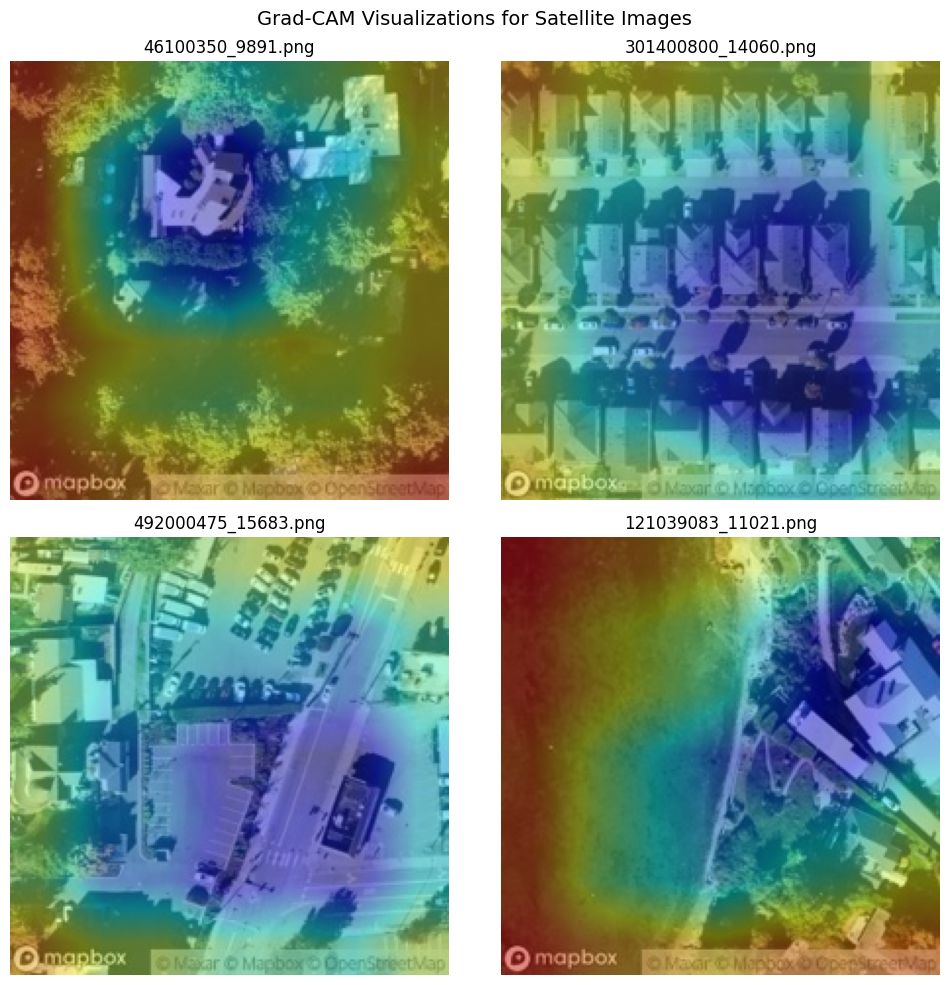

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for ax, img_path in zip(axes, image_paths):
    overlay = generate_gradcam(
        image_path=img_path,
        model=model,
        target_layer=target_layer,
        transform=transform,
        device=device
    )
    ax.imshow(overlay)
    ax.set_title(os.path.basename(img_path))
    ax.axis("off")

plt.suptitle("Grad-CAM Visualizations for Satellite Images", fontsize=14)
plt.tight_layout()
plt.show()

### Grad-CAM Analysis of Satellite Images

The Grad-CAM visualizations show which parts of the satellite images the CNN
considers important while learning visual features. Strong activation is seen
around green areas and water bodies, suggesting that these environmental
features play a meaningful role in the learned representations. In contrast,
road networks and neighborhood structure appear more spread out and less
sharply highlighted, which reflects their distributed nature across the image.
Overall, the visualizations indicate that the model captures useful
neighborhood-level context from satellite imagery.